In [1]:
"""
Fine-grained classification practice with Flower-17
"""

# Python Packages
import argparse
import os
import time
# 3rd Party Packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# User Packages
from start.preprocessing import ImageToTensorPreprocessor, ResizePreprocessor
from start.loader import ImageDataset
from start.model import MiniVGGNet


In [2]:
# Load Flowers-17 dataset
dataset = ImageDataset(
    preprocessors=[
        ResizePreprocessor(224, 224, aspect_preserving=True),
        ImageToTensorPreprocessor()
    ]
)
(data, labels) = dataset.load(
    dataset_path=r'/home/share/dataset/flowers17',
    verbosity=80
)

print('data shape: {}'.format(data.shape))
print('labels shape: {}'.format(labels.shape))

classes = set(labels)



[INFO] Processing label: dandelion
[INFO] processed 80 dandelion images
[INFO] Processing label: coltsfoot


[INFO] processed 80 coltsfoot images
[INFO] Processing label: lilyvalley
[INFO] processed 80 lilyvalley images
[INFO] Processing label: cowslip


[INFO] processed 80 cowslip images
[INFO] Processing label: iris
[INFO] processed 80 iris images
[INFO] Processing label: snowdrop


[INFO] processed 80 snowdrop images
[INFO] Processing label: sunflower
[INFO] processed 80 sunflower images
[INFO] Processing label: tigerlily


[INFO] processed 80 tigerlily images
[INFO] Processing label: daisy
[INFO] processed 80 daisy images
[INFO] Processing label: pansy


[INFO] processed 80 pansy images
[INFO] Processing label: crocus
[INFO] processed 80 crocus images
[INFO] Processing label: daffodil


[INFO] processed 80 daffodil images
[INFO] Processing label: fritillary
[INFO] processed 80 fritillary images
[INFO] Processing label: buttercup


[INFO] processed 80 buttercup images
[INFO] Processing label: windflower
[INFO] processed 80 windflower images
[INFO] Processing label: files.txt
[INFO] Processing label: tulip


[INFO] processed 80 tulip images
[INFO] Processing label: bluebell
[INFO] processed 80 bluebell images


data shape: (1360, 224, 224, 3)
labels shape: (1360,)


In [3]:
# Setup data splits
# Normalize data
data = data.astype(np.float) / 255.0
# Partition into train and test splits
(trainX, testX, trainY, testY) = train_test_split(
    data, labels,
    test_size=0.4,
    random_state=int(time.time())
)
(valX, testX, valY, testY) = train_test_split(
    testX, testY,
    test_size=0.5,
    random_state=int(time.time())
)

# Binarize output to one hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
valY = lb.fit_transform(valY)
testY = lb.fit_transform(testY)

# Data augmentation
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Initialize the optimizer and model
print('[INFO] compiling model...')
opt = SGD(lr=0.05)
properties = {
    'width':    64,
    'height':   64,
    'channels': 3,
    'classes':  len(classes)
}
#model = MiniVGGNet.build(properties)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.4, 
    depth_multiplier=1, 
    include_top=False, 
    weights='imagenet', 
    input_tensor=None, 
    pooling='avg'
))
model.add(Dense(
    units=len(classes),
    activation='softmax',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='glorot_uniform',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None
))
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()

[INFO] compiling model...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Model) (None, 1792)              4363712   
_________________________________________________________________
dense (Dense)                (None, 17)                30481     
Total params: 4,394,193
Trainable params: 4,346,257
Non-trainable params: 47,936
_________________________________________________________________


In [5]:
# Train the network
print('[INFO] training network...')
history = model.fit_generator(
    augmenter.flow(trainX, trainY, batch_size=32),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // 32,
    epochs=75,
    verbose=1
)

[INFO] training network...


Epoch 1/75


 1/25 [>.............................] - ETA: 1:37 - loss: 3.1753 - acc: 0.0000e+00

 2/25 [=>............................] - ETA: 50s - loss: 2.6756 - acc: 0.1719     

 3/25 [==>...........................] - ETA: 35s - loss: 2.4414 - acc: 0.2812

 4/25 [===>..........................] - ETA: 27s - loss: 2.1523 - acc: 0.4141

 5/25 [=====>........................] - ETA: 22s - loss: 1.9870 - acc: 0.4500

 6/25 [======>.......................] - ETA: 18s - loss: 1.8756 - acc: 0.4740

 7/25 [=======>......................] - ETA: 16s - loss: 1.8167 - acc: 0.4821

 8/25 [========>.....................] - ETA: 14s - loss: 1.7561 - acc: 0.4922

 9/25 [=========>....................] - ETA: 12s - loss: 1.7255 - acc: 0.5000

10/25 [===========>..................] - ETA: 11s - loss: 1.6279 - acc: 0.5281

11/25 [============>.................] - ETA: 10s - loss: 1.5786 - acc: 0.5455

12/25 [=============>................] - ETA: 9s - loss: 1.5095 - acc: 0.5729 

13/25 [==============>...............] - ETA: 8s - loss: 1.4335 - acc: 0.5938

14/25 [===============>..............] - ETA: 7s - loss: 1.3917 - acc: 0.6049

15/25 [=================>............] - ETA: 6s - loss: 1.3456 - acc: 0.6146

16/25 [==================>...........] - ETA: 5s - loss: 1.2863 - acc: 0.6289

17/25 [===================>..........] - ETA: 4s - loss: 1.2589 - acc: 0.6342

18/25 [====================>.........] - ETA: 4s - loss: 1.2048 - acc: 0.6493

19/25 [=====================>........] - ETA: 3s - loss: 1.1682 - acc: 0.6612

20/25 [=======================>......] - ETA: 2s - loss: 1.1370 - acc: 0.6656

21/25 [========================>.....] - ETA: 2s - loss: 1.0987 - acc: 0.6771

22/25 [=========================>....] - ETA: 1s - loss: 1.0616 - acc: 0.6875

23/25 [==========================>...] - ETA: 1s - loss: 1.0342 - acc: 0.6970

24/25 [===========================>..] - ETA: 0s - loss: 1.0010 - acc: 0.7070

25/25 [==============================] - 14s 566ms/step - loss: 0.9830 - acc: 0.7139 - val_loss: 2.6051 - val_acc: 0.2941


Epoch 2/75


 1/25 [>.............................] - ETA: 9s - loss: 0.4000 - acc: 0.9062

 2/25 [=>............................] - ETA: 9s - loss: 0.3352 - acc: 0.8906

 3/25 [==>...........................] - ETA: 8s - loss: 0.2737 - acc: 0.9062

 4/25 [===>..........................] - ETA: 8s - loss: 0.2857 - acc: 0.9062

 5/25 [=====>........................] - ETA: 7s - loss: 0.3099 - acc: 0.9062

 6/25 [======>.......................] - ETA: 7s - loss: 0.2838 - acc: 0.9167

 7/25 [=======>......................] - ETA: 6s - loss: 0.2718 - acc: 0.9196

 8/25 [========>.....................] - ETA: 6s - loss: 0.2471 - acc: 0.9258

 9/25 [=========>....................] - ETA: 6s - loss: 0.2303 - acc: 0.9340

10/25 [===========>..................] - ETA: 5s - loss: 0.2188 - acc: 0.9375

11/25 [============>.................] - ETA: 5s - loss: 0.2118 - acc: 0.9375

12/25 [=============>................] - ETA: 4s - loss: 0.2267 - acc: 0.9323

13/25 [==============>...............] - ETA: 4s - loss: 0.2444 - acc: 0.9255

14/25 [===============>..............] - ETA: 4s - loss: 0.2335 - acc: 0.9286

15/25 [=================>............] - ETA: 3s - loss: 0.2220 - acc: 0.9333

16/25 [==================>...........] - ETA: 3s - loss: 0.2204 - acc: 0.9336

17/25 [===================>..........] - ETA: 3s - loss: 0.2197 - acc: 0.9338

18/25 [====================>.........] - ETA: 2s - loss: 0.2168 - acc: 0.9358

19/25 [=====================>........] - ETA: 2s - loss: 0.2115 - acc: 0.9375

20/25 [=======================>......] - ETA: 1s - loss: 0.2059 - acc: 0.9406

21/25 [========================>.....] - ETA: 1s - loss: 0.2125 - acc: 0.9420

22/25 [=========================>....] - ETA: 1s - loss: 0.2110 - acc: 0.9418

23/25 [==========================>...] - ETA: 0s - loss: 0.2085 - acc: 0.9429

24/25 [===========================>..] - ETA: 0s - loss: 0.2026 - acc: 0.9453

25/25 [==============================] - 10s 398ms/step - loss: 0.2026 - acc: 0.9437 - val_loss: 1.9956 - val_acc: 0.4412


Epoch 3/75


 1/25 [>.............................] - ETA: 9s - loss: 0.5552 - acc: 0.9062

 2/25 [=>............................] - ETA: 8s - loss: 0.4393 - acc: 0.8906

 3/25 [==>...........................] - ETA: 8s - loss: 0.3263 - acc: 0.9062

 4/25 [===>..........................] - ETA: 7s - loss: 0.2544 - acc: 0.9297

 5/25 [=====>........................] - ETA: 7s - loss: 0.2599 - acc: 0.9313

 6/25 [======>.......................] - ETA: 6s - loss: 0.2775 - acc: 0.9219

 7/25 [=======>......................] - ETA: 6s - loss: 0.3108 - acc: 0.9196

 8/25 [========>.....................] - ETA: 6s - loss: 0.2810 - acc: 0.9258

 9/25 [=========>....................] - ETA: 5s - loss: 0.2769 - acc: 0.9236

10/25 [===========>..................] - ETA: 5s - loss: 0.2546 - acc: 0.9313

11/25 [============>.................] - ETA: 5s - loss: 0.2381 - acc: 0.9347

12/25 [=============>................] - ETA: 4s - loss: 0.2278 - acc: 0.9375

13/25 [==============>...............] - ETA: 4s - loss: 0.2159 - acc: 0.9399

14/25 [===============>..............] - ETA: 4s - loss: 0.2062 - acc: 0.9442

15/25 [=================>............] - ETA: 3s - loss: 0.2006 - acc: 0.9458

16/25 [==================>...........] - ETA: 3s - loss: 0.1943 - acc: 0.9473

17/25 [===================>..........] - ETA: 3s - loss: 0.1892 - acc: 0.9485

18/25 [====================>.........] - ETA: 2s - loss: 0.1827 - acc: 0.9497

19/25 [=====================>........] - ETA: 2s - loss: 0.1787 - acc: 0.9507

20/25 [=======================>......] - ETA: 1s - loss: 0.1736 - acc: 0.9516

21/25 [========================>.....] - ETA: 1s - loss: 0.1680 - acc: 0.9524

22/25 [=========================>....] - ETA: 1s - loss: 0.1615 - acc: 0.9545

23/25 [==========================>...] - ETA: 0s - loss: 0.1554 - acc: 0.9565

24/25 [===========================>..] - ETA: 0s - loss: 0.1566 - acc: 0.9570

25/25 [==============================] - 10s 399ms/step - loss: 0.1536 - acc: 0.9576 - val_loss: 2.1967 - val_acc: 0.4007


Epoch 4/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0706 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.1002 - acc: 0.9844

 3/25 [==>...........................] - ETA: 8s - loss: 0.0957 - acc: 0.9792

 4/25 [===>..........................] - ETA: 8s - loss: 0.0772 - acc: 0.9844

 5/25 [=====>........................] - ETA: 7s - loss: 0.0643 - acc: 0.9875

 6/25 [======>.......................] - ETA: 7s - loss: 0.0559 - acc: 0.9896

 7/25 [=======>......................] - ETA: 6s - loss: 0.0524 - acc: 0.9911

 8/25 [========>.....................] - ETA: 6s - loss: 0.0466 - acc: 0.9922

 9/25 [=========>....................] - ETA: 6s - loss: 0.0431 - acc: 0.9931

10/25 [===========>..................] - ETA: 5s - loss: 0.0421 - acc: 0.9938

11/25 [============>.................] - ETA: 5s - loss: 0.0409 - acc: 0.9943

12/25 [=============>................] - ETA: 4s - loss: 0.0390 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0365 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0353 - acc: 0.9955

15/25 [=================>............] - ETA: 3s - loss: 0.0398 - acc: 0.9917

16/25 [==================>...........] - ETA: 3s - loss: 0.0427 - acc: 0.9902

17/25 [===================>..........] - ETA: 3s - loss: 0.0666 - acc: 0.9890

18/25 [====================>.........] - ETA: 2s - loss: 0.0648 - acc: 0.9896

19/25 [=====================>........] - ETA: 2s - loss: 0.0617 - acc: 0.9901

20/25 [=======================>......] - ETA: 1s - loss: 0.0648 - acc: 0.9891

21/25 [========================>.....] - ETA: 1s - loss: 0.0728 - acc: 0.9866

22/25 [=========================>....] - ETA: 1s - loss: 0.0742 - acc: 0.9858

23/25 [==========================>...] - ETA: 0s - loss: 0.0776 - acc: 0.9851

24/25 [===========================>..] - ETA: 0s - loss: 0.0787 - acc: 0.9844

25/25 [==============================] - 10s 397ms/step - loss: 0.0790 - acc: 0.9850 - val_loss: 2.2306 - val_acc: 0.4265


Epoch 5/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0163 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0874 - acc: 0.9844

 3/25 [==>...........................] - ETA: 8s - loss: 0.1169 - acc: 0.9688

 4/25 [===>..........................] - ETA: 8s - loss: 0.1118 - acc: 0.9609

 5/25 [=====>........................] - ETA: 7s - loss: 0.1069 - acc: 0.9563

 6/25 [======>.......................] - ETA: 7s - loss: 0.0926 - acc: 0.9635

 7/25 [=======>......................] - ETA: 6s - loss: 0.0800 - acc: 0.9688

 8/25 [========>.....................] - ETA: 6s - loss: 0.0782 - acc: 0.9688

 9/25 [=========>....................] - ETA: 6s - loss: 0.0711 - acc: 0.9722

10/25 [===========>..................] - ETA: 5s - loss: 0.0648 - acc: 0.9750

11/25 [============>.................] - ETA: 5s - loss: 0.0596 - acc: 0.9773

12/25 [=============>................] - ETA: 4s - loss: 0.0678 - acc: 0.9740

13/25 [==============>...............] - ETA: 4s - loss: 0.0705 - acc: 0.9736

14/25 [===============>..............] - ETA: 4s - loss: 0.0664 - acc: 0.9754

15/25 [=================>............] - ETA: 3s - loss: 0.0626 - acc: 0.9771

16/25 [==================>...........] - ETA: 3s - loss: 0.0789 - acc: 0.9727

17/25 [===================>..........] - ETA: 3s - loss: 0.0755 - acc: 0.9743

18/25 [====================>.........] - ETA: 2s - loss: 0.0727 - acc: 0.9757

19/25 [=====================>........] - ETA: 2s - loss: 0.0694 - acc: 0.9770

20/25 [=======================>......] - ETA: 1s - loss: 0.0712 - acc: 0.9750

21/25 [========================>.....] - ETA: 1s - loss: 0.0750 - acc: 0.9732

22/25 [=========================>....] - ETA: 1s - loss: 0.0735 - acc: 0.9730

23/25 [==========================>...] - ETA: 0s - loss: 0.0728 - acc: 0.9728

24/25 [===========================>..] - ETA: 0s - loss: 0.0720 - acc: 0.9727

25/25 [==============================] - 10s 397ms/step - loss: 0.0699 - acc: 0.9738 - val_loss: 1.5317 - val_acc: 0.5662


Epoch 6/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0374 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0256 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0365 - acc: 0.9896

 4/25 [===>..........................] - ETA: 8s - loss: 0.0636 - acc: 0.9766

 5/25 [=====>........................] - ETA: 7s - loss: 0.0536 - acc: 0.9812

 6/25 [======>.......................] - ETA: 7s - loss: 0.0459 - acc: 0.9844

 7/25 [=======>......................] - ETA: 6s - loss: 0.0431 - acc: 0.9866

 8/25 [========>.....................] - ETA: 6s - loss: 0.0423 - acc: 0.9883

 9/25 [=========>....................] - ETA: 6s - loss: 0.0457 - acc: 0.9861

10/25 [===========>..................] - ETA: 5s - loss: 0.0460 - acc: 0.9844

11/25 [============>.................] - ETA: 5s - loss: 0.0491 - acc: 0.9830

12/25 [=============>................] - ETA: 4s - loss: 0.0499 - acc: 0.9818

13/25 [==============>...............] - ETA: 4s - loss: 0.0483 - acc: 0.9832

14/25 [===============>..............] - ETA: 4s - loss: 0.0454 - acc: 0.9844

15/25 [=================>............] - ETA: 3s - loss: 0.0452 - acc: 0.9854

16/25 [==================>...........] - ETA: 3s - loss: 0.0428 - acc: 0.9863

17/25 [===================>..........] - ETA: 3s - loss: 0.0412 - acc: 0.9871

18/25 [====================>.........] - ETA: 2s - loss: 0.0398 - acc: 0.9878

19/25 [=====================>........] - ETA: 2s - loss: 0.0386 - acc: 0.9885

20/25 [=======================>......] - ETA: 1s - loss: 0.0369 - acc: 0.9891

21/25 [========================>.....] - ETA: 1s - loss: 0.0353 - acc: 0.9896

22/25 [=========================>....] - ETA: 1s - loss: 0.0341 - acc: 0.9901

23/25 [==========================>...] - ETA: 0s - loss: 0.0328 - acc: 0.9905

24/25 [===========================>..] - ETA: 0s - loss: 0.0317 - acc: 0.9909

25/25 [==============================] - 10s 412ms/step - loss: 0.0306 - acc: 0.9912 - val_loss: 1.2580 - val_acc: 0.5993


Epoch 7/75


 1/25 [>.............................] - ETA: 10s - loss: 0.0316 - acc: 0.9688

 2/25 [=>............................] - ETA: 9s - loss: 0.0249 - acc: 0.9844 

 3/25 [==>...........................] - ETA: 9s - loss: 0.0549 - acc: 0.9792

 4/25 [===>..........................] - ETA: 8s - loss: 0.0459 - acc: 0.9844

 5/25 [=====>........................] - ETA: 8s - loss: 0.0391 - acc: 0.9875

 6/25 [======>.......................] - ETA: 7s - loss: 0.0335 - acc: 0.9896

 7/25 [=======>......................] - ETA: 7s - loss: 0.0348 - acc: 0.9911

 8/25 [========>.....................] - ETA: 6s - loss: 0.0322 - acc: 0.9922

 9/25 [=========>....................] - ETA: 6s - loss: 0.0303 - acc: 0.9931

10/25 [===========>..................] - ETA: 6s - loss: 0.0276 - acc: 0.9938

11/25 [============>.................] - ETA: 5s - loss: 0.0260 - acc: 0.9943

12/25 [=============>................] - ETA: 5s - loss: 0.0242 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0385 - acc: 0.9928

14/25 [===============>..............] - ETA: 4s - loss: 0.0464 - acc: 0.9888

15/25 [=================>............] - ETA: 4s - loss: 0.0463 - acc: 0.9875

16/25 [==================>...........] - ETA: 3s - loss: 0.0470 - acc: 0.9863

17/25 [===================>..........] - ETA: 3s - loss: 0.0445 - acc: 0.9871

18/25 [====================>.........] - ETA: 2s - loss: 0.0438 - acc: 0.9878

19/25 [=====================>........] - ETA: 2s - loss: 0.0437 - acc: 0.9868

20/25 [=======================>......] - ETA: 2s - loss: 0.0419 - acc: 0.9875

21/25 [========================>.....] - ETA: 1s - loss: 0.0410 - acc: 0.9881

22/25 [=========================>....] - ETA: 1s - loss: 0.0394 - acc: 0.9886

23/25 [==========================>...] - ETA: 0s - loss: 0.0388 - acc: 0.9891

24/25 [===========================>..] - ETA: 0s - loss: 0.0373 - acc: 0.9896

25/25 [==============================] - 11s 423ms/step - loss: 0.0369 - acc: 0.9900 - val_loss: 1.4089 - val_acc: 0.5625


Epoch 8/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0719 - acc: 0.9688

 2/25 [=>............................] - ETA: 9s - loss: 0.0437 - acc: 0.9844

 3/25 [==>...........................] - ETA: 7s - loss: 0.0372 - acc: 0.9896

 4/25 [===>..........................] - ETA: 7s - loss: 0.0413 - acc: 0.9844

 5/25 [=====>........................] - ETA: 7s - loss: 0.0347 - acc: 0.9875

 6/25 [======>.......................] - ETA: 6s - loss: 0.0294 - acc: 0.9896

 7/25 [=======>......................] - ETA: 6s - loss: 0.0269 - acc: 0.9911

 8/25 [========>.....................] - ETA: 6s - loss: 0.0247 - acc: 0.9922

 9/25 [=========>....................] - ETA: 5s - loss: 0.0223 - acc: 0.9931

10/25 [===========>..................] - ETA: 5s - loss: 0.0206 - acc: 0.9938

11/25 [============>.................] - ETA: 5s - loss: 0.0195 - acc: 0.9943

12/25 [=============>................] - ETA: 4s - loss: 0.0188 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0191 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0179 - acc: 0.9955

15/25 [=================>............] - ETA: 3s - loss: 0.0170 - acc: 0.9958

16/25 [==================>...........] - ETA: 3s - loss: 0.0164 - acc: 0.9961

17/25 [===================>..........] - ETA: 3s - loss: 0.0162 - acc: 0.9963

18/25 [====================>.........] - ETA: 2s - loss: 0.0159 - acc: 0.9965

19/25 [=====================>........] - ETA: 2s - loss: 0.0156 - acc: 0.9967

20/25 [=======================>......] - ETA: 1s - loss: 0.0150 - acc: 0.9969

21/25 [========================>.....] - ETA: 1s - loss: 0.0152 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0146 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0146 - acc: 0.9973

24/25 [===========================>..] - ETA: 0s - loss: 0.0141 - acc: 0.9974

25/25 [==============================] - 10s 399ms/step - loss: 0.0138 - acc: 0.9975 - val_loss: 1.2471 - val_acc: 0.6360


Epoch 9/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0044 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0135 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0098 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0122 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0130 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0115 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 0.0106 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0174 - acc: 0.9961

 9/25 [=========>....................] - ETA: 6s - loss: 0.0173 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0161 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0156 - acc: 0.9972

12/25 [=============>................] - ETA: 5s - loss: 0.0147 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0155 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0145 - acc: 0.9978

15/25 [=================>............] - ETA: 3s - loss: 0.0151 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0142 - acc: 0.9980

17/25 [===================>..........] - ETA: 3s - loss: 0.0144 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0147 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0140 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0135 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0136 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0131 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0126 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9987

25/25 [==============================] - 10s 414ms/step - loss: 0.0122 - acc: 0.9988 - val_loss: 1.0335 - val_acc: 0.7059


Epoch 10/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0050 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0201 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0142 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0113 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0096 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 0.0148 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0127 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0158 - acc: 0.9961

 9/25 [=========>....................] - ETA: 5s - loss: 0.0151 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0141 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0131 - acc: 0.9972

12/25 [=============>................] - ETA: 4s - loss: 0.0121 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0114 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0109 - acc: 0.9978

15/25 [=================>............] - ETA: 3s - loss: 0.0117 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0163 - acc: 0.9961

17/25 [===================>..........] - ETA: 3s - loss: 0.0155 - acc: 0.9963

18/25 [====================>.........] - ETA: 2s - loss: 0.0151 - acc: 0.9965

19/25 [=====================>........] - ETA: 2s - loss: 0.0144 - acc: 0.9967

20/25 [=======================>......] - ETA: 1s - loss: 0.0139 - acc: 0.9969

21/25 [========================>.....] - ETA: 1s - loss: 0.0139 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0144 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0139 - acc: 0.9973

24/25 [===========================>..] - ETA: 0s - loss: 0.0139 - acc: 0.9974

25/25 [==============================] - 10s 405ms/step - loss: 0.0141 - acc: 0.9975 - val_loss: 0.7554 - val_acc: 0.7647


Epoch 11/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0036 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0061 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0097 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0083 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0075 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0064 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0057 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0256 - acc: 0.9922

 9/25 [=========>....................] - ETA: 5s - loss: 0.0676 - acc: 0.9861

10/25 [===========>..................] - ETA: 5s - loss: 0.0612 - acc: 0.9875

11/25 [============>.................] - ETA: 5s - loss: 0.0785 - acc: 0.9858

12/25 [=============>................] - ETA: 4s - loss: 0.0721 - acc: 0.9870

13/25 [==============>...............] - ETA: 4s - loss: 0.0673 - acc: 0.9880

14/25 [===============>..............] - ETA: 4s - loss: 0.0656 - acc: 0.9888

15/25 [=================>............] - ETA: 3s - loss: 0.0620 - acc: 0.9896

16/25 [==================>...........] - ETA: 3s - loss: 0.0594 - acc: 0.9902

17/25 [===================>..........] - ETA: 2s - loss: 0.0564 - acc: 0.9908

18/25 [====================>.........] - ETA: 2s - loss: 0.0535 - acc: 0.9913

19/25 [=====================>........] - ETA: 2s - loss: 0.0550 - acc: 0.9885

20/25 [=======================>......] - ETA: 1s - loss: 0.0544 - acc: 0.9875

21/25 [========================>.....] - ETA: 1s - loss: 0.0519 - acc: 0.9881

22/25 [=========================>....] - ETA: 1s - loss: 0.0595 - acc: 0.9872

23/25 [==========================>...] - ETA: 0s - loss: 0.0581 - acc: 0.9864

24/25 [===========================>..] - ETA: 0s - loss: 0.0612 - acc: 0.9857

25/25 [==============================] - 10s 401ms/step - loss: 0.0591 - acc: 0.9863 - val_loss: 0.8547 - val_acc: 0.7537


Epoch 12/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0024 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0039 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0045 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0037 - acc: 1.0000

 5/25 [=====>........................] - ETA: 6s - loss: 0.0037 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 0.0061 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0055 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0052 - acc: 1.0000

 9/25 [=========>....................] - ETA: 5s - loss: 0.0058 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0056 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0126 - acc: 0.9972

12/25 [=============>................] - ETA: 4s - loss: 0.0143 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0155 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0145 - acc: 0.9955

15/25 [=================>............] - ETA: 3s - loss: 0.0137 - acc: 0.9958

16/25 [==================>...........] - ETA: 3s - loss: 0.0140 - acc: 0.9961

17/25 [===================>..........] - ETA: 2s - loss: 0.0132 - acc: 0.9963

18/25 [====================>.........] - ETA: 2s - loss: 0.0144 - acc: 0.9965

19/25 [=====================>........] - ETA: 2s - loss: 0.0146 - acc: 0.9967

20/25 [=======================>......] - ETA: 1s - loss: 0.0160 - acc: 0.9969

21/25 [========================>.....] - ETA: 1s - loss: 0.0153 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0151 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0146 - acc: 0.9973

24/25 [===========================>..] - ETA: 0s - loss: 0.0146 - acc: 0.9974

25/25 [==============================] - 10s 399ms/step - loss: 0.0170 - acc: 0.9962 - val_loss: 0.7728 - val_acc: 0.7757


Epoch 13/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0183 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0256 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0348 - acc: 0.9896

 4/25 [===>..........................] - ETA: 8s - loss: 0.0458 - acc: 0.9844

 5/25 [=====>........................] - ETA: 7s - loss: 0.0373 - acc: 0.9875

 6/25 [======>.......................] - ETA: 7s - loss: 0.0315 - acc: 0.9896

 7/25 [=======>......................] - ETA: 6s - loss: 0.0274 - acc: 0.9911

 8/25 [========>.....................] - ETA: 6s - loss: 0.0317 - acc: 0.9883

 9/25 [=========>....................] - ETA: 6s - loss: 0.0291 - acc: 0.9896

10/25 [===========>..................] - ETA: 5s - loss: 0.0422 - acc: 0.9844

11/25 [============>.................] - ETA: 5s - loss: 0.0488 - acc: 0.9830

12/25 [=============>................] - ETA: 5s - loss: 0.0461 - acc: 0.9844

13/25 [==============>...............] - ETA: 4s - loss: 0.0435 - acc: 0.9856

14/25 [===============>..............] - ETA: 4s - loss: 0.0406 - acc: 0.9866

15/25 [=================>............] - ETA: 3s - loss: 0.0380 - acc: 0.9875

16/25 [==================>...........] - ETA: 3s - loss: 0.0360 - acc: 0.9883

17/25 [===================>..........] - ETA: 3s - loss: 0.0342 - acc: 0.9890

18/25 [====================>.........] - ETA: 2s - loss: 0.0330 - acc: 0.9896

19/25 [=====================>........] - ETA: 2s - loss: 0.0317 - acc: 0.9901

20/25 [=======================>......] - ETA: 1s - loss: 0.0303 - acc: 0.9906

21/25 [========================>.....] - ETA: 1s - loss: 0.0290 - acc: 0.9911

22/25 [=========================>....] - ETA: 1s - loss: 0.0282 - acc: 0.9915

23/25 [==========================>...] - ETA: 0s - loss: 0.0278 - acc: 0.9918

24/25 [===========================>..] - ETA: 0s - loss: 0.0270 - acc: 0.9922

25/25 [==============================] - 10s 409ms/step - loss: 0.0261 - acc: 0.9925 - val_loss: 0.9981 - val_acc: 0.7426


Epoch 14/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0065 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0112 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0089 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0071 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0059 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0055 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0058 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0052 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0047 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0048 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0045 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0043 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0041 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0048 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0048 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0045 - acc: 1.0000

17/25 [===================>..........] - ETA: 2s - loss: 0.0045 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0044 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0044 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0042 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0041 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0045 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0044 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0042 - acc: 1.0000

25/25 [==============================] - 10s 403ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.8571 - val_acc: 0.7757


Epoch 15/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0050 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0088 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0075 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0088 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0076 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 0.0354 - acc: 0.9896

 7/25 [=======>......................] - ETA: 6s - loss: 0.0342 - acc: 0.9911

 8/25 [========>.....................] - ETA: 6s - loss: 0.0314 - acc: 0.9922

 9/25 [=========>....................] - ETA: 5s - loss: 0.0297 - acc: 0.9931

10/25 [===========>..................] - ETA: 5s - loss: 0.0269 - acc: 0.9938

11/25 [============>.................] - ETA: 5s - loss: 0.0246 - acc: 0.9943

12/25 [=============>................] - ETA: 4s - loss: 0.0229 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0225 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0266 - acc: 0.9933

15/25 [=================>............] - ETA: 3s - loss: 0.0249 - acc: 0.9938

16/25 [==================>...........] - ETA: 3s - loss: 0.0235 - acc: 0.9941

17/25 [===================>..........] - ETA: 3s - loss: 0.0227 - acc: 0.9945

18/25 [====================>.........] - ETA: 2s - loss: 0.0220 - acc: 0.9948

19/25 [=====================>........] - ETA: 2s - loss: 0.0249 - acc: 0.9934

20/25 [=======================>......] - ETA: 1s - loss: 0.0277 - acc: 0.9922

21/25 [========================>.....] - ETA: 1s - loss: 0.0265 - acc: 0.9926

22/25 [=========================>....] - ETA: 1s - loss: 0.0259 - acc: 0.9929

23/25 [==========================>...] - ETA: 0s - loss: 0.0267 - acc: 0.9918

24/25 [===========================>..] - ETA: 0s - loss: 0.0261 - acc: 0.9922

25/25 [==============================] - 10s 404ms/step - loss: 0.0255 - acc: 0.9925 - val_loss: 0.9162 - val_acc: 0.7463


Epoch 16/75


 1/25 [>.............................] - ETA: 4s - loss: 0.0328 - acc: 1.0000

 2/25 [=>............................] - ETA: 6s - loss: 0.0494 - acc: 0.9844

 3/25 [==>...........................] - ETA: 7s - loss: 0.0341 - acc: 0.9896

 4/25 [===>..........................] - ETA: 7s - loss: 0.0257 - acc: 0.9922

 5/25 [=====>........................] - ETA: 6s - loss: 0.0235 - acc: 0.9938

 6/25 [======>.......................] - ETA: 6s - loss: 0.0215 - acc: 0.9948

 7/25 [=======>......................] - ETA: 6s - loss: 0.0231 - acc: 0.9911

 8/25 [========>.....................] - ETA: 6s - loss: 0.0204 - acc: 0.9922

 9/25 [=========>....................] - ETA: 5s - loss: 0.0192 - acc: 0.9931

10/25 [===========>..................] - ETA: 5s - loss: 0.0177 - acc: 0.9938

11/25 [============>.................] - ETA: 5s - loss: 0.0163 - acc: 0.9943

12/25 [=============>................] - ETA: 4s - loss: 0.0314 - acc: 0.9896

13/25 [==============>...............] - ETA: 4s - loss: 0.0315 - acc: 0.9880

14/25 [===============>..............] - ETA: 4s - loss: 0.0315 - acc: 0.9888

15/25 [=================>............] - ETA: 3s - loss: 0.0354 - acc: 0.9875

16/25 [==================>...........] - ETA: 3s - loss: 0.0333 - acc: 0.9883

17/25 [===================>..........] - ETA: 2s - loss: 0.0332 - acc: 0.9890

18/25 [====================>.........] - ETA: 2s - loss: 0.0315 - acc: 0.9896

19/25 [=====================>........] - ETA: 2s - loss: 0.0299 - acc: 0.9901

20/25 [=======================>......] - ETA: 1s - loss: 0.0340 - acc: 0.9875

21/25 [========================>.....] - ETA: 1s - loss: 0.0325 - acc: 0.9881

22/25 [=========================>....] - ETA: 1s - loss: 0.0348 - acc: 0.9872

23/25 [==========================>...] - ETA: 0s - loss: 0.0338 - acc: 0.9878

24/25 [===========================>..] - ETA: 0s - loss: 0.0338 - acc: 0.9883

25/25 [==============================] - 10s 392ms/step - loss: 0.0325 - acc: 0.9888 - val_loss: 0.8755 - val_acc: 0.7647


Epoch 17/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0080 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0070 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0053 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0056 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0046 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0044 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0040 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0038 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0038 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0038 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0035 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0045 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0050 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0051 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0104 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0107 - acc: 0.9980

17/25 [===================>..........] - ETA: 3s - loss: 0.0107 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0102 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0097 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0095 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0093 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0090 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0087 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0084 - acc: 0.9987

25/25 [==============================] - 10s 409ms/step - loss: 0.0082 - acc: 0.9988 - val_loss: 0.6218 - val_acc: 0.7941


Epoch 18/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0102 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0072 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0093 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0230 - acc: 0.9922

 5/25 [=====>........................] - ETA: 7s - loss: 0.0214 - acc: 0.9938

 6/25 [======>.......................] - ETA: 7s - loss: 0.0200 - acc: 0.9948

 7/25 [=======>......................] - ETA: 6s - loss: 0.0182 - acc: 0.9955

 8/25 [========>.....................] - ETA: 6s - loss: 0.0217 - acc: 0.9922

 9/25 [=========>....................] - ETA: 6s - loss: 0.0195 - acc: 0.9931

10/25 [===========>..................] - ETA: 5s - loss: 0.0177 - acc: 0.9938

11/25 [============>.................] - ETA: 5s - loss: 0.0314 - acc: 0.9915

12/25 [=============>................] - ETA: 5s - loss: 0.0294 - acc: 0.9922

13/25 [==============>...............] - ETA: 4s - loss: 0.0276 - acc: 0.9928

14/25 [===============>..............] - ETA: 4s - loss: 0.0256 - acc: 0.9933

15/25 [=================>............] - ETA: 3s - loss: 0.0241 - acc: 0.9938

16/25 [==================>...........] - ETA: 3s - loss: 0.0230 - acc: 0.9941

17/25 [===================>..........] - ETA: 3s - loss: 0.0271 - acc: 0.9926

18/25 [====================>.........] - ETA: 2s - loss: 0.0257 - acc: 0.9931

19/25 [=====================>........] - ETA: 2s - loss: 0.0245 - acc: 0.9934

20/25 [=======================>......] - ETA: 1s - loss: 0.0234 - acc: 0.9938

21/25 [========================>.....] - ETA: 1s - loss: 0.0224 - acc: 0.9940

22/25 [=========================>....] - ETA: 1s - loss: 0.0215 - acc: 0.9943

23/25 [==========================>...] - ETA: 0s - loss: 0.0207 - acc: 0.9946

24/25 [===========================>..] - ETA: 0s - loss: 0.0199 - acc: 0.9948

25/25 [==============================] - 10s 396ms/step - loss: 0.0192 - acc: 0.9950 - val_loss: 0.6728 - val_acc: 0.8125


Epoch 19/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0022 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0019 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0022 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0034 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0029 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0027 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0029 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0027 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0037 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0034 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0032 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0030 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0029 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0048 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0046 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0044 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0041 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0066 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0063 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0061 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0058 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0056 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0058 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0065 - acc: 0.9987

25/25 [==============================] - 10s 399ms/step - loss: 0.0064 - acc: 0.9987 - val_loss: 0.9280 - val_acc: 0.7426


Epoch 20/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0037 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0026 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0035 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0033 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0034 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0031 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 0.0027 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0143 - acc: 0.9961

 9/25 [=========>....................] - ETA: 6s - loss: 0.0157 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0142 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0130 - acc: 0.9972

12/25 [=============>................] - ETA: 5s - loss: 0.0120 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0115 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0108 - acc: 0.9978

15/25 [=================>............] - ETA: 3s - loss: 0.0107 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0101 - acc: 0.9980

17/25 [===================>..........] - ETA: 3s - loss: 0.0099 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0094 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0104 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0099 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0096 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0092 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0089 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0087 - acc: 0.9987

25/25 [==============================] - 10s 403ms/step - loss: 0.0084 - acc: 0.9987 - val_loss: 0.7027 - val_acc: 0.7537


Epoch 21/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0049 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0027 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0184 - acc: 0.9896

 4/25 [===>..........................] - ETA: 7s - loss: 0.0237 - acc: 0.9844

 5/25 [=====>........................] - ETA: 7s - loss: 0.0195 - acc: 0.9875

 6/25 [======>.......................] - ETA: 7s - loss: 0.0258 - acc: 0.9844

 7/25 [=======>......................] - ETA: 6s - loss: 0.0227 - acc: 0.9866

 8/25 [========>.....................] - ETA: 6s - loss: 0.0200 - acc: 0.9883

 9/25 [=========>....................] - ETA: 6s - loss: 0.0180 - acc: 0.9896

10/25 [===========>..................] - ETA: 5s - loss: 0.0164 - acc: 0.9906

11/25 [============>.................] - ETA: 5s - loss: 0.0155 - acc: 0.9915

12/25 [=============>................] - ETA: 5s - loss: 0.0145 - acc: 0.9922

13/25 [==============>...............] - ETA: 4s - loss: 0.0141 - acc: 0.9928

14/25 [===============>..............] - ETA: 4s - loss: 0.0131 - acc: 0.9933

15/25 [=================>............] - ETA: 3s - loss: 0.0171 - acc: 0.9917

16/25 [==================>...........] - ETA: 3s - loss: 0.0162 - acc: 0.9922

17/25 [===================>..........] - ETA: 3s - loss: 0.0158 - acc: 0.9926

18/25 [====================>.........] - ETA: 2s - loss: 0.0154 - acc: 0.9931

19/25 [=====================>........] - ETA: 2s - loss: 0.0148 - acc: 0.9934

20/25 [=======================>......] - ETA: 1s - loss: 0.0152 - acc: 0.9938

21/25 [========================>.....] - ETA: 1s - loss: 0.0151 - acc: 0.9940

22/25 [=========================>....] - ETA: 1s - loss: 0.0166 - acc: 0.9943

23/25 [==========================>...] - ETA: 0s - loss: 0.0160 - acc: 0.9946

24/25 [===========================>..] - ETA: 0s - loss: 0.0155 - acc: 0.9948

25/25 [==============================] - 10s 408ms/step - loss: 0.0149 - acc: 0.9950 - val_loss: 0.4272 - val_acc: 0.8713


Epoch 22/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0051 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0046 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0033 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0103 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0154 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0132 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0198 - acc: 0.9955

 8/25 [========>.....................] - ETA: 6s - loss: 0.0175 - acc: 0.9961

 9/25 [=========>....................] - ETA: 6s - loss: 0.0163 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0149 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0224 - acc: 0.9943

12/25 [=============>................] - ETA: 4s - loss: 0.0208 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0194 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0200 - acc: 0.9955

15/25 [=================>............] - ETA: 3s - loss: 0.0190 - acc: 0.9958

16/25 [==================>...........] - ETA: 3s - loss: 0.0179 - acc: 0.9961

17/25 [===================>..........] - ETA: 3s - loss: 0.0171 - acc: 0.9963

18/25 [====================>.........] - ETA: 2s - loss: 0.0181 - acc: 0.9965

19/25 [=====================>........] - ETA: 2s - loss: 0.0172 - acc: 0.9967

20/25 [=======================>......] - ETA: 1s - loss: 0.0168 - acc: 0.9969

21/25 [========================>.....] - ETA: 1s - loss: 0.0162 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0155 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0148 - acc: 0.9973

24/25 [===========================>..] - ETA: 0s - loss: 0.0154 - acc: 0.9961

25/25 [==============================] - 10s 391ms/step - loss: 0.0148 - acc: 0.9962 - val_loss: 0.7249 - val_acc: 0.8088


Epoch 23/75


 1/25 [>.............................] - ETA: 8s - loss: 0.0415 - acc: 0.9688

 2/25 [=>............................] - ETA: 8s - loss: 0.0213 - acc: 0.9844

 3/25 [==>...........................] - ETA: 8s - loss: 0.0149 - acc: 0.9896

 4/25 [===>..........................] - ETA: 7s - loss: 0.0117 - acc: 0.9922

 5/25 [=====>........................] - ETA: 7s - loss: 0.0159 - acc: 0.9875

 6/25 [======>.......................] - ETA: 7s - loss: 0.0138 - acc: 0.9896

 7/25 [=======>......................] - ETA: 6s - loss: 0.0120 - acc: 0.9911

 8/25 [========>.....................] - ETA: 6s - loss: 0.0107 - acc: 0.9922

 9/25 [=========>....................] - ETA: 6s - loss: 0.0096 - acc: 0.9931

10/25 [===========>..................] - ETA: 5s - loss: 0.0089 - acc: 0.9938

11/25 [============>.................] - ETA: 5s - loss: 0.0082 - acc: 0.9943

12/25 [=============>................] - ETA: 4s - loss: 0.0080 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0079 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0074 - acc: 0.9955

15/25 [=================>............] - ETA: 3s - loss: 0.0070 - acc: 0.9958

16/25 [==================>...........] - ETA: 3s - loss: 0.0066 - acc: 0.9961

17/25 [===================>..........] - ETA: 3s - loss: 0.0063 - acc: 0.9963

18/25 [====================>.........] - ETA: 2s - loss: 0.0060 - acc: 0.9965

19/25 [=====================>........] - ETA: 2s - loss: 0.0060 - acc: 0.9967

20/25 [=======================>......] - ETA: 1s - loss: 0.0058 - acc: 0.9969

21/25 [========================>.....] - ETA: 1s - loss: 0.0056 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0055 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0053 - acc: 0.9973

24/25 [===========================>..] - ETA: 0s - loss: 0.0051 - acc: 0.9974

25/25 [==============================] - 10s 397ms/step - loss: 0.0051 - acc: 0.9975 - val_loss: 0.6467 - val_acc: 0.8235


Epoch 24/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0043 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0151 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0101 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0078 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0068 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0057 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0050 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0044 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0040 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0037 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0034 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0032 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0031 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0030 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0029 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0028 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0026 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0025 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0024 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0023 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0022 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0025 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0025 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000

25/25 [==============================] - 10s 391ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.5914 - val_acc: 0.8346


Epoch 25/75


 1/25 [>.............................] - ETA: 8s - loss: 0.0030 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0026 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0022 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0024 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0022 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0026 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0030 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0143 - acc: 0.9961

 9/25 [=========>....................] - ETA: 6s - loss: 0.0155 - acc: 0.9931

10/25 [===========>..................] - ETA: 5s - loss: 0.0140 - acc: 0.9938

11/25 [============>.................] - ETA: 5s - loss: 0.0128 - acc: 0.9943

12/25 [=============>................] - ETA: 4s - loss: 0.0117 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0110 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0104 - acc: 0.9955

15/25 [=================>............] - ETA: 3s - loss: 0.0100 - acc: 0.9958

16/25 [==================>...........] - ETA: 3s - loss: 0.0094 - acc: 0.9961

17/25 [===================>..........] - ETA: 2s - loss: 0.0090 - acc: 0.9963

18/25 [====================>.........] - ETA: 2s - loss: 0.0086 - acc: 0.9965

19/25 [=====================>........] - ETA: 2s - loss: 0.0081 - acc: 0.9967

20/25 [=======================>......] - ETA: 1s - loss: 0.0077 - acc: 0.9969

21/25 [========================>.....] - ETA: 1s - loss: 0.0074 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0071 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0073 - acc: 0.9973

24/25 [===========================>..] - ETA: 0s - loss: 0.0070 - acc: 0.9974

25/25 [==============================] - 10s 392ms/step - loss: 0.0072 - acc: 0.9975 - val_loss: 0.6064 - val_acc: 0.8382


Epoch 26/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0474 - acc: 0.9688

 2/25 [=>............................] - ETA: 6s - loss: 0.0241 - acc: 0.9844

 3/25 [==>...........................] - ETA: 7s - loss: 0.0164 - acc: 0.9896

 4/25 [===>..........................] - ETA: 7s - loss: 0.0125 - acc: 0.9922

 5/25 [=====>........................] - ETA: 6s - loss: 0.0103 - acc: 0.9938

 6/25 [======>.......................] - ETA: 6s - loss: 0.0092 - acc: 0.9948

 7/25 [=======>......................] - ETA: 6s - loss: 0.0081 - acc: 0.9955

 8/25 [========>.....................] - ETA: 6s - loss: 0.0072 - acc: 0.9961

 9/25 [=========>....................] - ETA: 5s - loss: 0.0067 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0060 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0056 - acc: 0.9972

12/25 [=============>................] - ETA: 4s - loss: 0.0053 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0050 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0048 - acc: 0.9978

15/25 [=================>............] - ETA: 3s - loss: 0.0045 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0045 - acc: 0.9980

17/25 [===================>..........] - ETA: 2s - loss: 0.0048 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0047 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0045 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0044 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0043 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0045 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0044 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0042 - acc: 0.9987

25/25 [==============================] - 10s 390ms/step - loss: 0.0041 - acc: 0.9987 - val_loss: 0.5633 - val_acc: 0.8456


Epoch 27/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0028 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0031 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0023 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0018 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0015 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0013 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0012 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0011 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0013 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0030 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0037 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0034 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0032 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0033 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0033 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0031 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0030 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0029 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0027 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0027 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0026 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0025 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0025 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000

25/25 [==============================] - 10s 394ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4994 - val_acc: 0.8640


Epoch 28/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0017 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 9.6307e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 7.9220e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0016 - acc: 1.0000    

 5/25 [=====>........................] - ETA: 7s - loss: 0.0015 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0018 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0016 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0039 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0085 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0078 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0072 - acc: 0.9972

12/25 [=============>................] - ETA: 4s - loss: 0.0067 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0063 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0059 - acc: 0.9978

15/25 [=================>............] - ETA: 3s - loss: 0.0056 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0053 - acc: 0.9980

17/25 [===================>..........] - ETA: 2s - loss: 0.0050 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0048 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0046 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0044 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0043 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0043 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0041 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0042 - acc: 0.9987

25/25 [==============================] - 10s 398ms/step - loss: 0.0041 - acc: 0.9987 - val_loss: 0.4744 - val_acc: 0.8750


Epoch 29/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0039 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0021 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0230 - acc: 0.9896

 4/25 [===>..........................] - ETA: 8s - loss: 0.0175 - acc: 0.9922

 5/25 [=====>........................] - ETA: 7s - loss: 0.0509 - acc: 0.9875

 6/25 [======>.......................] - ETA: 7s - loss: 0.0426 - acc: 0.9896

 7/25 [=======>......................] - ETA: 6s - loss: 0.0372 - acc: 0.9911

 8/25 [========>.....................] - ETA: 6s - loss: 0.0329 - acc: 0.9922

 9/25 [=========>....................] - ETA: 6s - loss: 0.0294 - acc: 0.9931

10/25 [===========>..................] - ETA: 5s - loss: 0.0279 - acc: 0.9938

11/25 [============>.................] - ETA: 5s - loss: 0.0255 - acc: 0.9943

12/25 [=============>................] - ETA: 4s - loss: 0.0245 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0241 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0224 - acc: 0.9955

15/25 [=================>............] - ETA: 3s - loss: 0.0210 - acc: 0.9958

16/25 [==================>...........] - ETA: 3s - loss: 0.0217 - acc: 0.9941

17/25 [===================>..........] - ETA: 3s - loss: 0.0204 - acc: 0.9945

18/25 [====================>.........] - ETA: 2s - loss: 0.0194 - acc: 0.9948

19/25 [=====================>........] - ETA: 2s - loss: 0.0185 - acc: 0.9951

20/25 [=======================>......] - ETA: 1s - loss: 0.0176 - acc: 0.9953

21/25 [========================>.....] - ETA: 1s - loss: 0.0170 - acc: 0.9955

22/25 [=========================>....] - ETA: 1s - loss: 0.0163 - acc: 0.9957

23/25 [==========================>...] - ETA: 0s - loss: 0.0157 - acc: 0.9959

24/25 [===========================>..] - ETA: 0s - loss: 0.0150 - acc: 0.9961

25/25 [==============================] - 10s 402ms/step - loss: 0.0145 - acc: 0.9962 - val_loss: 0.4222 - val_acc: 0.8787


Epoch 30/75


 1/25 [>.............................] - ETA: 9s - loss: 7.8650e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 6.1412e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 6.3501e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 5.5485e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 9.9325e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0011 - acc: 1.0000    

 7/25 [=======>......................] - ETA: 7s - loss: 0.0012 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0011 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0015 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0017 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0029 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0028 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0026 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0040 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0040 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0050 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0048 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0045 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0046 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0044 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0044 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0042 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0040 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0040 - acc: 1.0000

25/25 [==============================] - 10s 415ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.4400 - val_acc: 0.8676


Epoch 31/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0120 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0062 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0176 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0135 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0109 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0099 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 0.0086 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0077 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0071 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0065 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0059 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0054 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0051 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0048 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0046 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0043 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0042 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0040 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0039 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0038 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0036 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0035 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0034 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0032 - acc: 1.0000

25/25 [==============================] - 11s 420ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4583 - val_acc: 0.8676


Epoch 32/75


 1/25 [>.............................] - ETA: 5s - loss: 0.0027 - acc: 1.0000

 2/25 [=>............................] - ETA: 7s - loss: 0.0017 - acc: 1.0000

 3/25 [==>...........................] - ETA: 7s - loss: 0.0017 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0016 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0034 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 0.0029 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0026 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0023 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0021 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0020 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0019 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0018 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0017 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0016 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0015 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0015 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0014 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0014 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0013 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0013 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0013 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0015 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0015 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 1.0000

25/25 [==============================] - 10s 406ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4238 - val_acc: 0.8787


Epoch 33/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0028 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0020 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0014 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0011 - acc: 1.0000

 5/25 [=====>........................] - ETA: 8s - loss: 9.5145e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 8.2684e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 0.0014 - acc: 1.0000    

 8/25 [========>.....................] - ETA: 6s - loss: 0.0013 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0012 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0015 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0014 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0014 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0012 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0052 - acc: 0.9980

17/25 [===================>..........] - ETA: 3s - loss: 0.0049 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0050 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0047 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0051 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0064 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0062 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0067 - acc: 0.9973

24/25 [===========================>..] - ETA: 0s - loss: 0.0064 - acc: 0.9974

25/25 [==============================] - 10s 412ms/step - loss: 0.0061 - acc: 0.9975 - val_loss: 0.3087 - val_acc: 0.9118


Epoch 34/75


 1/25 [>.............................] - ETA: 10s - loss: 0.0016 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0039 - acc: 1.0000 

 3/25 [==>...........................] - ETA: 8s - loss: 0.0029 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0023 - acc: 1.0000

 5/25 [=====>........................] - ETA: 8s - loss: 0.0022 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0040 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 0.0035 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0031 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0038 - acc: 1.0000

10/25 [===========>..................] - ETA: 6s - loss: 0.0034 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0031 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0030 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0028 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0026 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0025 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0024 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0023 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0069 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0066 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0064 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0082 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0080 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0148 - acc: 0.9959

24/25 [===========================>..] - ETA: 0s - loss: 0.0142 - acc: 0.9961

25/25 [==============================] - 10s 415ms/step - loss: 0.0201 - acc: 0.9950 - val_loss: 0.4016 - val_acc: 0.8934


Epoch 35/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0031 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0145 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0600 - acc: 0.9896

 4/25 [===>..........................] - ETA: 8s - loss: 0.0456 - acc: 0.9922

 5/25 [=====>........................] - ETA: 7s - loss: 0.0366 - acc: 0.9938

 6/25 [======>.......................] - ETA: 7s - loss: 0.0306 - acc: 0.9948

 7/25 [=======>......................] - ETA: 7s - loss: 0.0267 - acc: 0.9955

 8/25 [========>.....................] - ETA: 6s - loss: 0.0237 - acc: 0.9961

 9/25 [=========>....................] - ETA: 6s - loss: 0.0211 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0190 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0174 - acc: 0.9972

12/25 [=============>................] - ETA: 5s - loss: 0.0161 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0209 - acc: 0.9928

14/25 [===============>..............] - ETA: 4s - loss: 0.0194 - acc: 0.9933

15/25 [=================>............] - ETA: 3s - loss: 0.0310 - acc: 0.9917

16/25 [==================>...........] - ETA: 3s - loss: 0.0290 - acc: 0.9922

17/25 [===================>..........] - ETA: 3s - loss: 0.0274 - acc: 0.9926

18/25 [====================>.........] - ETA: 2s - loss: 0.0259 - acc: 0.9931

19/25 [=====================>........] - ETA: 2s - loss: 0.0249 - acc: 0.9934

20/25 [=======================>......] - ETA: 1s - loss: 0.0237 - acc: 0.9938

21/25 [========================>.....] - ETA: 1s - loss: 0.0227 - acc: 0.9940

22/25 [=========================>....] - ETA: 1s - loss: 0.0218 - acc: 0.9943

23/25 [==========================>...] - ETA: 0s - loss: 0.0209 - acc: 0.9946

24/25 [===========================>..] - ETA: 0s - loss: 0.0201 - acc: 0.9948

25/25 [==============================] - 10s 415ms/step - loss: 0.0193 - acc: 0.9950 - val_loss: 0.3105 - val_acc: 0.9044


Epoch 36/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0011 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 8.9566e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 9.7114e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0033 - acc: 1.0000    

 5/25 [=====>........................] - ETA: 7s - loss: 0.0028 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0025 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 0.0026 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0031 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0038 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0050 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0047 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0044 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0042 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0039 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0038 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0036 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0034 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0034 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0034 - acc: 1.0000

20/25 [=======================>......] - ETA: 2s - loss: 0.0034 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0032 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0032 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0031 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 1.0000

25/25 [==============================] - 11s 422ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.2782 - val_acc: 0.9081


Epoch 37/75


 1/25 [>.............................] - ETA: 9s - loss: 4.0594e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 7s - loss: 0.0070 - acc: 1.0000    

 3/25 [==>...........................] - ETA: 7s - loss: 0.0048 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0042 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0034 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0029 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0027 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0024 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0021 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0022 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0036 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0034 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0032 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0033 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0031 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0029 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0028 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0027 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0026 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0025 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0025 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0026 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0025 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000

25/25 [==============================] - 10s 419ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.2582 - val_acc: 0.9081


Epoch 38/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0015 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0014 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0011 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0010 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0014 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 0.0014 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0014 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0012 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0073 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0067 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0072 - acc: 0.9972

12/25 [=============>................] - ETA: 4s - loss: 0.0066 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0061 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0060 - acc: 0.9978

15/25 [=================>............] - ETA: 3s - loss: 0.0058 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0055 - acc: 0.9980

17/25 [===================>..........] - ETA: 3s - loss: 0.0052 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0057 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0056 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0053 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0051 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0049 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0047 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0049 - acc: 0.9987

25/25 [==============================] - 10s 406ms/step - loss: 0.0047 - acc: 0.9987 - val_loss: 0.2627 - val_acc: 0.9118


Epoch 39/75


 1/25 [>.............................] - ETA: 9s - loss: 8.8700e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0014 - acc: 1.0000    

 3/25 [==>...........................] - ETA: 8s - loss: 0.0020 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0016 - acc: 1.0000

 5/25 [=====>........................] - ETA: 8s - loss: 0.0013 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0011 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 9.9080e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 8.9988e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0036 - acc: 1.0000    

10/25 [===========>..................] - ETA: 6s - loss: 0.0033 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0030 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0028 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0027 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0025 - acc: 1.0000

15/25 [=================>............] - ETA: 4s - loss: 0.0024 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0025 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0024 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0043 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0041 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0039 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0037 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0036 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0034 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0033 - acc: 1.0000

25/25 [==============================] - 11s 422ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2313 - val_acc: 0.9265


Epoch 40/75


 1/25 [>.............................] - ETA: 10s - loss: 2.2316e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 8.8418e-04 - acc: 1.0000 

 3/25 [==>...........................] - ETA: 9s - loss: 0.0012 - acc: 1.0000    

 4/25 [===>..........................] - ETA: 8s - loss: 9.7198e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 8s - loss: 7.8646e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 7.2407e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 6.6688e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 6.3180e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 6.7760e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 6s - loss: 8.5116e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 9.3902e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 9.7065e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0010 - acc: 1.0000    

14/25 [===============>..............] - ETA: 4s - loss: 9.6158e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 4s - loss: 9.5329e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 9.2465e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 9.4244e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0012 - acc: 1.0000    

19/25 [=====================>........] - ETA: 2s - loss: 0.0011 - acc: 1.0000

20/25 [=======================>......] - ETA: 2s - loss: 0.0017 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0019 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0018 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0018 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 1.0000

25/25 [==============================] - 11s 429ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.2042 - val_acc: 0.9301


Epoch 41/75


 1/25 [>.............................] - ETA: 10s - loss: 1.5733e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0017 - acc: 1.0000     

 3/25 [==>...........................] - ETA: 8s - loss: 0.0012 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0014 - acc: 1.0000

 5/25 [=====>........................] - ETA: 8s - loss: 0.0013 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0011 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 9.8267e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0012 - acc: 1.0000    

 9/25 [=========>....................] - ETA: 6s - loss: 0.0011 - acc: 1.0000

10/25 [===========>..................] - ETA: 6s - loss: 9.7548e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 9.3860e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 9.0161e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 8.8398e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 8.7694e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0013 - acc: 1.0000    

16/25 [==================>...........] - ETA: 3s - loss: 0.0012 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0012 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0011 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0011 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0010 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0010 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 9.7590e-04 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 9.4250e-04 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 9.5665e-04 - acc: 1.0000

25/25 [==============================] - 10s 412ms/step - loss: 9.4448e-04 - acc: 1.0000 - val_loss: 0.1893 - val_acc: 0.9375


Epoch 42/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0015 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 9.0434e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 8.3930e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0031 - acc: 1.0000    

 5/25 [=====>........................] - ETA: 8s - loss: 0.0025 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0022 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 0.0019 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0017 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0017 - acc: 1.0000

10/25 [===========>..................] - ETA: 6s - loss: 0.0016 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0015 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0014 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0012 - acc: 1.0000

15/25 [=================>............] - ETA: 4s - loss: 0.0012 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0012 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0011 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0011 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0010 - acc: 1.0000

20/25 [=======================>......] - ETA: 2s - loss: 0.0010 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0012 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0012 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0012 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 1.0000

25/25 [==============================] - 11s 426ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1745 - val_acc: 0.9412


Epoch 43/75


 1/25 [>.............................] - ETA: 9s - loss: 1.6061e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 3.7032e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 9s - loss: 2.7764e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 3.2469e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 8s - loss: 4.7001e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 4.1523e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 6.0341e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 5.5704e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 5.5681e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 6s - loss: 5.2123e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 5.4009e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0033 - acc: 1.0000    

13/25 [==============>...............] - ETA: 4s - loss: 0.0031 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0029 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0028 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0026 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0025 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0024 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0022 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0022 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0021 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0022 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0022 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0021 - acc: 1.0000

25/25 [==============================] - 10s 411ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.1914 - val_acc: 0.9412


Epoch 44/75


 1/25 [>.............................] - ETA: 10s - loss: 9.8590e-05 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0014 - acc: 1.0000     

 3/25 [==>...........................] - ETA: 9s - loss: 0.0011 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 9.4005e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 8s - loss: 7.9920e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 6.8275e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 6.0869e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 5.9353e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 6.2495e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 6s - loss: 6.9907e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 6.5793e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0064 - acc: 0.9948    

13/25 [==============>...............] - ETA: 4s - loss: 0.0059 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0055 - acc: 0.9955

15/25 [=================>............] - ETA: 4s - loss: 0.0052 - acc: 0.9958

16/25 [==================>...........] - ETA: 3s - loss: 0.0049 - acc: 0.9961

17/25 [===================>..........] - ETA: 3s - loss: 0.0047 - acc: 0.9963

18/25 [====================>.........] - ETA: 2s - loss: 0.0044 - acc: 0.9965

19/25 [=====================>........] - ETA: 2s - loss: 0.0042 - acc: 0.9967

20/25 [=======================>......] - ETA: 1s - loss: 0.0040 - acc: 0.9969

21/25 [========================>.....] - ETA: 1s - loss: 0.0038 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0037 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0041 - acc: 0.9973

24/25 [===========================>..] - ETA: 0s - loss: 0.0040 - acc: 0.9974

25/25 [==============================] - 11s 424ms/step - loss: 0.0039 - acc: 0.9975 - val_loss: 0.1992 - val_acc: 0.9412


Epoch 45/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0014 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0010 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 7.2167e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 7.1290e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 8.9297e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 9.4924e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0011 - acc: 1.0000    

 8/25 [========>.....................] - ETA: 6s - loss: 0.0013 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0014 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0013 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0021 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0020 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0019 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0018 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0020 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0020 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0019 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0018 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0017 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0017 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0019 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0018 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0017 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 1.0000

25/25 [==============================] - 10s 414ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.1507 - val_acc: 0.9559


Epoch 46/75


 1/25 [>.............................] - ETA: 9s - loss: 3.9877e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 2.7982e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 2.6961e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0043 - acc: 1.0000    

 5/25 [=====>........................] - ETA: 7s - loss: 0.0041 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 0.0035 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0030 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0026 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0024 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0024 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0034 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0031 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0030 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0028 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0026 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0025 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0025 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0024 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0028 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0026 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0025 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0024 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0046 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0047 - acc: 1.0000

25/25 [==============================] - 10s 404ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.1355 - val_acc: 0.9522


Epoch 47/75


 1/25 [>.............................] - ETA: 10s - loss: 4.9649e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 5.4884e-04 - acc: 1.0000 

 3/25 [==>...........................] - ETA: 8s - loss: 0.0074 - acc: 1.0000    

 4/25 [===>..........................] - ETA: 8s - loss: 0.0477 - acc: 0.9922

 5/25 [=====>........................] - ETA: 8s - loss: 0.0394 - acc: 0.9938

 6/25 [======>.......................] - ETA: 7s - loss: 0.0329 - acc: 0.9948

 7/25 [=======>......................] - ETA: 7s - loss: 0.0341 - acc: 0.9955

 8/25 [========>.....................] - ETA: 6s - loss: 0.0299 - acc: 0.9961

 9/25 [=========>....................] - ETA: 6s - loss: 0.0281 - acc: 0.9965

10/25 [===========>..................] - ETA: 6s - loss: 0.0255 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0232 - acc: 0.9972

12/25 [=============>................] - ETA: 5s - loss: 0.0215 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0199 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0187 - acc: 0.9978

15/25 [=================>............] - ETA: 4s - loss: 0.0175 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0164 - acc: 0.9980

17/25 [===================>..........] - ETA: 3s - loss: 0.0156 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0148 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0144 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0139 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0133 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0127 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0123 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0118 - acc: 0.9987

25/25 [==============================] - 10s 406ms/step - loss: 0.0115 - acc: 0.9987 - val_loss: 0.1776 - val_acc: 0.9301


Epoch 48/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0078 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0040 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0028 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0021 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0018 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0044 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0038 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0034 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0031 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0029 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0030 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0028 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0029 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0029 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0027 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0025 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0024 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0023 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0022 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0022 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0022 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0021 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0022 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 1.0000

25/25 [==============================] - 10s 396ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.1758 - val_acc: 0.9301


Epoch 49/75


 1/25 [>.............................] - ETA: 8s - loss: 1.7933e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 8.9045e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 9.5983e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 8.1643e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 8.9503e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 8.5696e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 9.7248e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 9.2626e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0013 - acc: 1.0000    

10/25 [===========>..................] - ETA: 5s - loss: 0.0012 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0011 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0012 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0011 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0010 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 9.7920e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0020 - acc: 1.0000    

17/25 [===================>..........] - ETA: 3s - loss: 0.0019 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0018 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0018 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0017 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0017 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0016 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0015 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 1.0000

25/25 [==============================] - 10s 403ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.1475 - val_acc: 0.9522


Epoch 50/75


 1/25 [>.............................] - ETA: 9s - loss: 2.0507e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 3.2936e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 3.0952e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 3.5812e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 4.9743e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 4.4152e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 4.0338e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 4.2117e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 5.3681e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 5.0694e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 4.7522e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 4.8825e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 5.6962e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 7.0831e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 9.2941e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 8.9808e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 8.6252e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 8.4340e-04 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 9.6489e-04 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0010 - acc: 1.0000    

21/25 [========================>.....] - ETA: 1s - loss: 0.0010 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0012 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0012 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 1.0000

25/25 [==============================] - 10s 392ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.1333 - val_acc: 0.9559


Epoch 51/75


 1/25 [>.............................] - ETA: 8s - loss: 1.9780e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 1.1981e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0144 - acc: 1.0000    

 4/25 [===>..........................] - ETA: 7s - loss: 0.0112 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0105 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0095 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0082 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0072 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0065 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0059 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0060 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0055 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0051 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0047 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0065 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0061 - acc: 0.9980

17/25 [===================>..........] - ETA: 2s - loss: 0.0102 - acc: 0.9945

18/25 [====================>.........] - ETA: 2s - loss: 0.0098 - acc: 0.9948

19/25 [=====================>........] - ETA: 2s - loss: 0.0128 - acc: 0.9934

20/25 [=======================>......] - ETA: 1s - loss: 0.0123 - acc: 0.9938

21/25 [========================>.....] - ETA: 1s - loss: 0.0117 - acc: 0.9940

22/25 [=========================>....] - ETA: 1s - loss: 0.0121 - acc: 0.9943

23/25 [==========================>...] - ETA: 0s - loss: 0.0118 - acc: 0.9946

24/25 [===========================>..] - ETA: 0s - loss: 0.0114 - acc: 0.9948

25/25 [==============================] - 10s 393ms/step - loss: 0.0113 - acc: 0.9950 - val_loss: 0.2474 - val_acc: 0.9301


Epoch 52/75


 1/25 [>.............................] - ETA: 8s - loss: 1.9239e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 9.8429e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0011 - acc: 1.0000    

 4/25 [===>..........................] - ETA: 7s - loss: 0.0011 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0011 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0011 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 9.1972e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0010 - acc: 1.0000    

 9/25 [=========>....................] - ETA: 6s - loss: 0.0055 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0055 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0051 - acc: 0.9972

12/25 [=============>................] - ETA: 4s - loss: 0.0049 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0046 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0043 - acc: 0.9978

15/25 [=================>............] - ETA: 3s - loss: 0.0040 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0042 - acc: 0.9980

17/25 [===================>..........] - ETA: 2s - loss: 0.0041 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0038 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0036 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0035 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0033 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0032 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0031 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 0.9987

25/25 [==============================] - 10s 392ms/step - loss: 0.0029 - acc: 0.9987 - val_loss: 0.2082 - val_acc: 0.9522


Epoch 53/75


 1/25 [>.............................] - ETA: 9s - loss: 3.7410e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0013 - acc: 1.0000    

 3/25 [==>...........................] - ETA: 8s - loss: 9.2992e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 7.3939e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 6.3035e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 6.9756e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 6.8975e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 6.5708e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 9.2439e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 8.5267e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 7.8022e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 7.2878e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 6.9447e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 6.6748e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 6.7789e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0057 - acc: 1.0000    

17/25 [===================>..........] - ETA: 2s - loss: 0.0054 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0053 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0050 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0049 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0052 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0050 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0048 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0047 - acc: 1.0000

25/25 [==============================] - 10s 395ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.1668 - val_acc: 0.9596


Epoch 54/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0118 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0061 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0043 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0033 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0032 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0027 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0026 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0024 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0022 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0020 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0019 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0018 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0017 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0016 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0015 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0015 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0022 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0021 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0020 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0019 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0019 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0018 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0017 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 1.0000

25/25 [==============================] - 10s 399ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.1615 - val_acc: 0.9522


Epoch 55/75


 1/25 [>.............................] - ETA: 9s - loss: 6.8260e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 4.1376e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 3.3279e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0106 - acc: 0.9922    

 5/25 [=====>........................] - ETA: 7s - loss: 0.0086 - acc: 0.9938

 6/25 [======>.......................] - ETA: 7s - loss: 0.0074 - acc: 0.9948

 7/25 [=======>......................] - ETA: 6s - loss: 0.0076 - acc: 0.9955

 8/25 [========>.....................] - ETA: 6s - loss: 0.0067 - acc: 0.9961

 9/25 [=========>....................] - ETA: 5s - loss: 0.0077 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0070 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0090 - acc: 0.9972

12/25 [=============>................] - ETA: 4s - loss: 0.0087 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0081 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0078 - acc: 0.9978

15/25 [=================>............] - ETA: 3s - loss: 0.0074 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0069 - acc: 0.9980

17/25 [===================>..........] - ETA: 2s - loss: 0.0065 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0065 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0064 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0061 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0062 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0061 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0060 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0057 - acc: 0.9987

25/25 [==============================] - 10s 399ms/step - loss: 0.0056 - acc: 0.9987 - val_loss: 0.1649 - val_acc: 0.9632


Epoch 56/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0056 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0035 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0035 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0039 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0035 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0030 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0026 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0028 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0025 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0023 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0022 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0020 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0019 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0018 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0017 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0016 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0015 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0014 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0014 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0014 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0014 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0014 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0013 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 1.0000

25/25 [==============================] - 10s 407ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.1542 - val_acc: 0.9669


Epoch 57/75


 1/25 [>.............................] - ETA: 5s - loss: 0.0031 - acc: 1.0000

 2/25 [=>............................] - ETA: 7s - loss: 0.0017 - acc: 1.0000

 3/25 [==>...........................] - ETA: 7s - loss: 0.0012 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0015 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0015 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 0.0022 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0019 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0017 - acc: 1.0000

 9/25 [=========>....................] - ETA: 5s - loss: 0.0017 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0033 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0030 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0028 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0026 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0024 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0023 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0022 - acc: 1.0000

17/25 [===================>..........] - ETA: 2s - loss: 0.0023 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0022 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0022 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0032 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0031 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0030 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0034 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0033 - acc: 0.9987

25/25 [==============================] - 10s 391ms/step - loss: 0.0033 - acc: 0.9987 - val_loss: 0.4201 - val_acc: 0.9375


Epoch 58/75


 1/25 [>.............................] - ETA: 9s - loss: 3.6867e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 3.3186e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 4.4719e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 0.0400 - acc: 0.9922    

 5/25 [=====>........................] - ETA: 7s - loss: 0.0326 - acc: 0.9938

 6/25 [======>.......................] - ETA: 7s - loss: 0.0273 - acc: 0.9948

 7/25 [=======>......................] - ETA: 6s - loss: 0.0237 - acc: 0.9955

 8/25 [========>.....................] - ETA: 6s - loss: 0.0210 - acc: 0.9961

 9/25 [=========>....................] - ETA: 6s - loss: 0.0189 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0170 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0156 - acc: 0.9972

12/25 [=============>................] - ETA: 5s - loss: 0.0239 - acc: 0.9948

13/25 [==============>...............] - ETA: 4s - loss: 0.0222 - acc: 0.9952

14/25 [===============>..............] - ETA: 4s - loss: 0.0206 - acc: 0.9955

15/25 [=================>............] - ETA: 3s - loss: 0.0193 - acc: 0.9958

16/25 [==================>...........] - ETA: 3s - loss: 0.0183 - acc: 0.9961

17/25 [===================>..........] - ETA: 3s - loss: 0.0172 - acc: 0.9963

18/25 [====================>.........] - ETA: 2s - loss: 0.0163 - acc: 0.9965

19/25 [=====================>........] - ETA: 2s - loss: 0.0155 - acc: 0.9967

20/25 [=======================>......] - ETA: 1s - loss: 0.0148 - acc: 0.9969

21/25 [========================>.....] - ETA: 1s - loss: 0.0141 - acc: 0.9970

22/25 [=========================>....] - ETA: 1s - loss: 0.0135 - acc: 0.9972

23/25 [==========================>...] - ETA: 0s - loss: 0.0136 - acc: 0.9973

24/25 [===========================>..] - ETA: 0s - loss: 0.0130 - acc: 0.9974

25/25 [==============================] - 10s 403ms/step - loss: 0.0126 - acc: 0.9975 - val_loss: 0.3843 - val_acc: 0.9228


Epoch 59/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0035 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0034 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0028 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0025 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0022 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0109 - acc: 0.9948

 7/25 [=======>......................] - ETA: 6s - loss: 0.0094 - acc: 0.9955

 8/25 [========>.....................] - ETA: 6s - loss: 0.0082 - acc: 0.9961

 9/25 [=========>....................] - ETA: 6s - loss: 0.0075 - acc: 0.9965

10/25 [===========>..................] - ETA: 5s - loss: 0.0089 - acc: 0.9969

11/25 [============>.................] - ETA: 5s - loss: 0.0083 - acc: 0.9972

12/25 [=============>................] - ETA: 4s - loss: 0.0078 - acc: 0.9974

13/25 [==============>...............] - ETA: 4s - loss: 0.0073 - acc: 0.9976

14/25 [===============>..............] - ETA: 4s - loss: 0.0068 - acc: 0.9978

15/25 [=================>............] - ETA: 3s - loss: 0.0063 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0061 - acc: 0.9980

17/25 [===================>..........] - ETA: 3s - loss: 0.0058 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0055 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0053 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0051 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0049 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0048 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0046 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0044 - acc: 0.9987

25/25 [==============================] - 10s 400ms/step - loss: 0.0043 - acc: 0.9987 - val_loss: 0.2370 - val_acc: 0.9412


Epoch 60/75


 1/25 [>.............................] - ETA: 9s - loss: 8.9075e-05 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0013 - acc: 1.0000    

 3/25 [==>...........................] - ETA: 8s - loss: 9.1869e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 8.3936e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 7.7458e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 6.5974e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 5.8278e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 5.1977e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 4.8272e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 5.8153e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 6.9937e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 9.6090e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 8.9804e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 8.9611e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0013 - acc: 1.0000    

16/25 [==================>...........] - ETA: 3s - loss: 0.0012 - acc: 1.0000

17/25 [===================>..........] - ETA: 2s - loss: 0.0013 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0012 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0012 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0012 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0011 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0011 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0011 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0011 - acc: 1.0000

25/25 [==============================] - 10s 401ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.2111 - val_acc: 0.9522


Epoch 61/75


 1/25 [>.............................] - ETA: 9s - loss: 2.0617e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 1.6552e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 1.8484e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 2.0962e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 2.3154e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 2.1682e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 2.6580e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 2.5249e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 2.5105e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 4.9762e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0012 - acc: 1.0000    

12/25 [=============>................] - ETA: 4s - loss: 0.0011 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0010 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0010 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 9.8063e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 9.7472e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 9.6582e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 9.2703e-04 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 9.7784e-04 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 9.4760e-04 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0010 - acc: 1.0000    

22/25 [=========================>....] - ETA: 1s - loss: 0.0010 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 9.6248e-04 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 9.2727e-04 - acc: 1.0000

25/25 [==============================] - 10s 397ms/step - loss: 8.9544e-04 - acc: 1.0000 - val_loss: 0.2088 - val_acc: 0.9449


Epoch 62/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0264 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0136 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0099 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 0.0075 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0061 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0051 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0044 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0039 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0037 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0034 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0031 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0028 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0026 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0025 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0046 - acc: 0.9979

16/25 [==================>...........] - ETA: 3s - loss: 0.0055 - acc: 0.9980

17/25 [===================>..........] - ETA: 3s - loss: 0.0053 - acc: 0.9982

18/25 [====================>.........] - ETA: 2s - loss: 0.0050 - acc: 0.9983

19/25 [=====================>........] - ETA: 2s - loss: 0.0048 - acc: 0.9984

20/25 [=======================>......] - ETA: 1s - loss: 0.0046 - acc: 0.9984

21/25 [========================>.....] - ETA: 1s - loss: 0.0044 - acc: 0.9985

22/25 [=========================>....] - ETA: 1s - loss: 0.0042 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0041 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0041 - acc: 0.9987

25/25 [==============================] - 10s 407ms/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.1786 - val_acc: 0.9449


Epoch 63/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0033 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0018 - acc: 1.0000

 3/25 [==>...........................] - ETA: 7s - loss: 0.0013 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 9.9898e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 6s - loss: 8.7117e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 7.5838e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 6.8319e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 6.1623e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 5s - loss: 6.6389e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 6.1773e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 6.0843e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 5.7265e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 5.3863e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 7.2545e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 8.4486e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 8.2012e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 2s - loss: 8.4794e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 8.3747e-04 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 8.6596e-04 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 9.8793e-04 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 9.5783e-04 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 9.2235e-04 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 9.1612e-04 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 8.8467e-04 - acc: 1.0000

25/25 [==============================] - 10s 391ms/step - loss: 9.1412e-04 - acc: 1.0000 - val_loss: 0.1662 - val_acc: 0.9449


Epoch 64/75


 1/25 [>.............................] - ETA: 9s - loss: 1.8225e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 1.9783e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 2.9917e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 2.5614e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 8.3366e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 0.0027 - acc: 1.0000    

 7/25 [=======>......................] - ETA: 7s - loss: 0.0023 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0020 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 0.0019 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0017 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0016 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 0.0015 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0014 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0012 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0015 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 0.0014 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0015 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0014 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0014 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0013 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0013 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0013 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 1.0000

25/25 [==============================] - 10s 410ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1652 - val_acc: 0.9485


Epoch 65/75


 1/25 [>.............................] - ETA: 9s - loss: 0.0018 - acc: 1.0000

 2/25 [=>............................] - ETA: 9s - loss: 0.0010 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 7.7444e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 6.1436e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 5.9684e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 5.7405e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 5.5666e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 5.8701e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 7.0475e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 8.7820e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 8.5455e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 7.9946e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 8.7204e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 8.1303e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 7.7954e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 7.5222e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 7.1398e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 6.9010e-04 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 6.5813e-04 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 6.6299e-04 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 6.5226e-04 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 6.3469e-04 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 6.6199e-04 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 6.4066e-04 - acc: 1.0000

25/25 [==============================] - 10s 403ms/step - loss: 6.2444e-04 - acc: 1.0000 - val_loss: 0.1557 - val_acc: 0.9485


Epoch 66/75


 1/25 [>.............................] - ETA: 9s - loss: 5.1984e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 4.5653e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 0.0012 - acc: 1.0000    

 4/25 [===>..........................] - ETA: 8s - loss: 0.0016 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 0.0014 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 0.0021 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 0.0018 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 0.0016 - acc: 1.0000

 9/25 [=========>....................] - ETA: 5s - loss: 0.0014 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 0.0014 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 0.0013 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 0.0013 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 0.0012 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 0.0015 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 0.0014 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 0.0014 - acc: 1.0000

17/25 [===================>..........] - ETA: 2s - loss: 0.0014 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 0.0015 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 0.0014 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 0.0013 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0013 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 0.0012 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 0.0012 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 1.0000

25/25 [==============================] - 10s 397ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1416 - val_acc: 0.9559


Epoch 67/75


 1/25 [>.............................] - ETA: 9s - loss: 1.3163e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 2.0310e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 1.6682e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 1.6968e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 1.4950e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 2.9743e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 2.7020e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 2.5854e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 2.4115e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 3.2648e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 3.1911e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 3.0121e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 2.8240e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 2.6906e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 2.7776e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 2.7543e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 2.7274e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 2.6376e-04 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 2.9291e-04 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 2.9688e-04 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 3.0947e-04 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 3.5061e-04 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 3.6484e-04 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 3.5834e-04 - acc: 1.0000

25/25 [==============================] - 10s 404ms/step - loss: 3.5446e-04 - acc: 1.0000 - val_loss: 0.1339 - val_acc: 0.9559


Epoch 68/75


 1/25 [>.............................] - ETA: 9s - loss: 1.0301e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 7.7449e-05 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 3.1055e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 7.5196e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 6.0612e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 6.0243e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 9.3542e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 8.4201e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 5s - loss: 8.1962e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 7.9468e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 8.1437e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 7.6985e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 7.3755e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 7.0757e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 9.3262e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 8.8551e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 2s - loss: 8.5273e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 8.1048e-04 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 7.8040e-04 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 7.6080e-04 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 7.2967e-04 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 7.0299e-04 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 6.7820e-04 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 6.5578e-04 - acc: 1.0000

25/25 [==============================] - 10s 386ms/step - loss: 6.5518e-04 - acc: 1.0000 - val_loss: 0.1343 - val_acc: 0.9596


Epoch 69/75


 1/25 [>.............................] - ETA: 9s - loss: 2.2503e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 1.6099e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 3.6974e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 3.7764e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 3.6135e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 3.0591e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 2.7851e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 3.2028e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 2.9101e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 2.6888e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 2.6160e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 2.4903e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 2.7439e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 3.0148e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 3.4444e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 3.3522e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 3.8452e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 3.6737e-04 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 3.5146e-04 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 3.4178e-04 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 0.0028 - acc: 0.9985    

22/25 [=========================>....] - ETA: 1s - loss: 0.0027 - acc: 0.9986

23/25 [==========================>...] - ETA: 0s - loss: 0.0027 - acc: 0.9986

24/25 [===========================>..] - ETA: 0s - loss: 0.0026 - acc: 0.9987

25/25 [==============================] - 10s 400ms/step - loss: 0.0025 - acc: 0.9988 - val_loss: 0.1650 - val_acc: 0.9632


Epoch 70/75


 1/25 [>.............................] - ETA: 5s - loss: 9.3552e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 6s - loss: 7.3141e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 7s - loss: 5.8359e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 7s - loss: 5.0560e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 6s - loss: 4.5300e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 6s - loss: 4.1415e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 3.7380e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 3.7034e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 5s - loss: 3.3413e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 3.0767e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 3.0741e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 3.2358e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 3.0629e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 3.0576e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 3.1363e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 3.0944e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 2s - loss: 3.2824e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 3.2685e-04 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 3.2140e-04 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 3.5174e-04 - acc: 1.0000

21/25 [========================>.....] - ETA: 1s - loss: 5.5024e-04 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 5.2713e-04 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 7.6218e-04 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 7.4149e-04 - acc: 1.0000

25/25 [==============================] - 10s 388ms/step - loss: 7.3383e-04 - acc: 1.0000 - val_loss: 0.1584 - val_acc: 0.9632


Epoch 71/75


 1/25 [>.............................] - ETA: 9s - loss: 2.6057e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 0.0011 - acc: 1.0000    

 3/25 [==>...........................] - ETA: 8s - loss: 8.8638e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 7.1238e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 5.9666e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 5.2125e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 6s - loss: 4.5513e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 4.3201e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 5.0091e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 6.5548e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 6.7022e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 4s - loss: 6.2004e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 5.9035e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 5.9806e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 5.6011e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 5.4721e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 5.2606e-04 - acc: 1.0000

18/25 [====================>.........] - ETA: 2s - loss: 5.0112e-04 - acc: 1.0000

19/25 [=====================>........] - ETA: 2s - loss: 4.9551e-04 - acc: 1.0000

20/25 [=======================>......] - ETA: 1s - loss: 5.3079e-04 - acc: 1.0000



21/25 [========================>.....] - ETA: 1s - loss: 7.6288e-04 - acc: 1.0000

22/25 [=========================>....] - ETA: 1s - loss: 7.3902e-04 - acc: 1.0000

23/25 [==========================>...] - ETA: 0s - loss: 7.2782e-04 - acc: 1.0000

24/25 [===========================>..] - ETA: 0s - loss: 7.1155e-04 - acc: 1.0000

25/25 [==============================] - 10s 396ms/step - loss: 6.9024e-04 - acc: 1.0000 - val_loss: 0.1496 - val_acc: 0.9632


Epoch 72/75


 1/25 [>.............................] - ETA: 9s - loss: 6.3159e-04 - acc: 1.0000

 2/25 [=>............................] - ETA: 8s - loss: 3.4698e-04 - acc: 1.0000

 3/25 [==>...........................] - ETA: 8s - loss: 4.2608e-04 - acc: 1.0000

 4/25 [===>..........................] - ETA: 8s - loss: 3.6543e-04 - acc: 1.0000

 5/25 [=====>........................] - ETA: 7s - loss: 2.9855e-04 - acc: 1.0000

 6/25 [======>.......................] - ETA: 7s - loss: 4.0836e-04 - acc: 1.0000

 7/25 [=======>......................] - ETA: 7s - loss: 3.8119e-04 - acc: 1.0000

 8/25 [========>.....................] - ETA: 6s - loss: 4.1555e-04 - acc: 1.0000

 9/25 [=========>....................] - ETA: 6s - loss: 3.7962e-04 - acc: 1.0000

10/25 [===========>..................] - ETA: 5s - loss: 3.8294e-04 - acc: 1.0000

11/25 [============>.................] - ETA: 5s - loss: 3.5757e-04 - acc: 1.0000

12/25 [=============>................] - ETA: 5s - loss: 3.4365e-04 - acc: 1.0000

13/25 [==============>...............] - ETA: 4s - loss: 4.7171e-04 - acc: 1.0000

14/25 [===============>..............] - ETA: 4s - loss: 4.4178e-04 - acc: 1.0000

15/25 [=================>............] - ETA: 3s - loss: 4.2415e-04 - acc: 1.0000

16/25 [==================>...........] - ETA: 3s - loss: 4.1584e-04 - acc: 1.0000

17/25 [===================>..........] - ETA: 3s - loss: 4.0764e-04 - acc: 1.0000

[INFO] evaluating network...


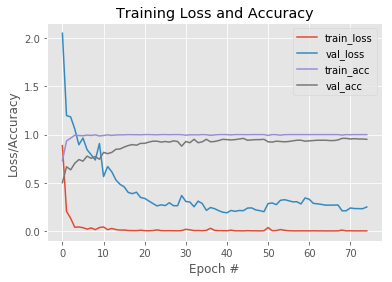

In [7]:
import pycm

# Evaluate the network
print('[INFO] evaluating network...')
predictions = model.predict(testX, batch_size=32)

cm = pycm.ConfusionMatrix(
    actual_vector=lb.inverse_transform(testY),
    predict_vector=lb.inverse_transform(predictions)
)
cm.save_html(r'output/confusion_matrix.html')

# Plot the training loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, 75), history.history['loss'], label='train_loss')
plt.plot(np.arange(0, 75), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, 75), history.history['acc'], label='train_acc')
plt.plot(np.arange(0, 75), history.history['val_acc'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()